<a href="https://colab.research.google.com/github/AlfonsoRafel/Posgrado-IA---UBA/blob/master/11.%20Analisis%20de%20Datos/TP_Integrador_An%C3%A1lisis_de_datos5_Alfonso_Rafel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de datos - Trabajo final integrador

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQATNC-EBwF-LIbDVv_L0gkP2V6oKQzah5GRg&usqp=CAU"/>

Se propone realizar el ciclo completo del desarrollo de un modelo de aprendizaje automático supervisado.

Trabajaremos con un [dataset de Kaggle con datos de por distintas estaciones metereológicas de Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package?select=weatherAUS.csv).

El objetivo es predecir si lloverá o no al día siguiente (variable *RainTomorrow*), en función datos metereológicos del día actual.


In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%%capture
!pip install funpymodeling
!pip install category_encoders

In [3]:
import numpy as np
import pandas as pd
import sklearn as sk
import funpymodeling as fp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown as md
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
file_path = '/content/gdrive/MyDrive/Alfonso/CEIA/Bimestre V/Análisis de Datos/weatherAUS.csv'
df = pd.read_csv(file_path)

### 1. Análisis exploratorio inicial

Visulización de las primeras filas.

In [15]:
df.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Datos característicos del dataset.

In [16]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


Generamos una tabla con:
* Cantidad de instancias nan por variable
* Porcentaje de nan por variable 
* Cantidad de valores cero por variable
* Porcentaje de valores cero por variables
* Cardinalidad por variable (valores únicos)
* Tipo de dato 

In [17]:
fp.status(df)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,Date,0,0.000000,0,0.000000,3436,object
1,Location,0,0.000000,0,0.000000,49,object
2,MinTemp,1485,0.010209,159,0.001093,389,float64
3,MaxTemp,1261,0.008669,14,0.000096,505,float64
4,Rainfall,3261,0.022419,91080,0.626152,681,float64
5,Evaporation,62790,0.431665,244,0.001677,358,float64
6,Sunshine,69835,0.480098,2359,0.016218,145,float64
7,WindGustDir,10326,0.070989,0,0.000000,16,object
8,WindGustSpeed,10263,0.070555,0,0.000000,67,float64
9,WindDir9am,10566,0.072639,0,0.000000,16,object


Clasificación de variables I:

- Fecha/Hora: Date 
- Numéricas: MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Humidity3pm, Pressure9am, Pressure3pm, Temp9am, Temp3pm
- Categóricas nominales: Location, WindGustDir, WindDir9pm, WindDir3pm, RainToday, Cloud9am, Cloud3pmRainTomorrow


Clasificación de variables II:

- Entrada: Date, Location, Cloud9am, Cloud3pm, MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Humidity3pm, Pressure9am, Pressure3pm, Temp9am, Temp3pm, WindGustDir, WindDir9pm, WindDir3pm, RainToday

- Salida: RainTomorrow



Todas las variables de entrada podrian ser informativas para un problema de clasificacion. Rainfall y Evaporation presentan una gran cantidad de valores 0, por lo cual podrian ser dos variables a prescindir, en caso que se confirme que no presenta relación con la salida (a revisarse en análisis posteriores).

#### Variables de Entrada

Histograma de variables numéricas.

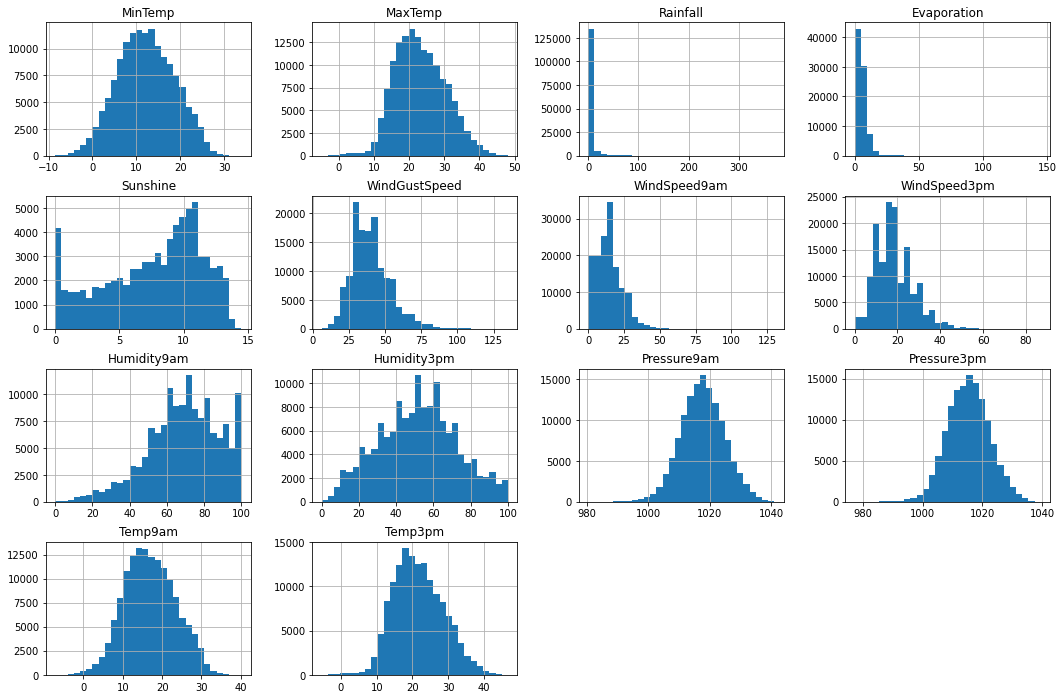

In [18]:
df_num = df.drop(df[['Cloud3pm','Cloud9am','Location', 'WindGustDir', 'Date', 'WindDir9am', 'WindDir3pm', 'RainToday',
                     'RainTomorrow']], axis=1, inplace=False)
df_hist = df_num.hist(bins=30, figsize=(18,12))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


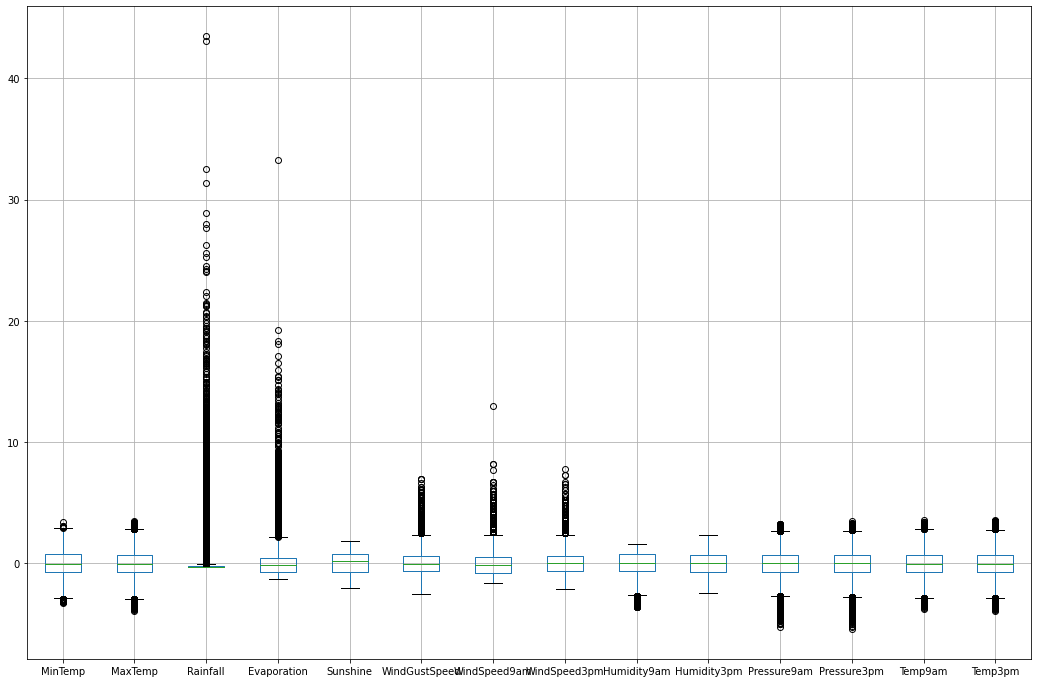

In [19]:
std = StandardScaler()
df_num_std = pd.DataFrame(data= std.fit_transform(df_num), columns=df_num.columns)
df_boxplot = df_num_std.boxplot(figsize=(18,12))

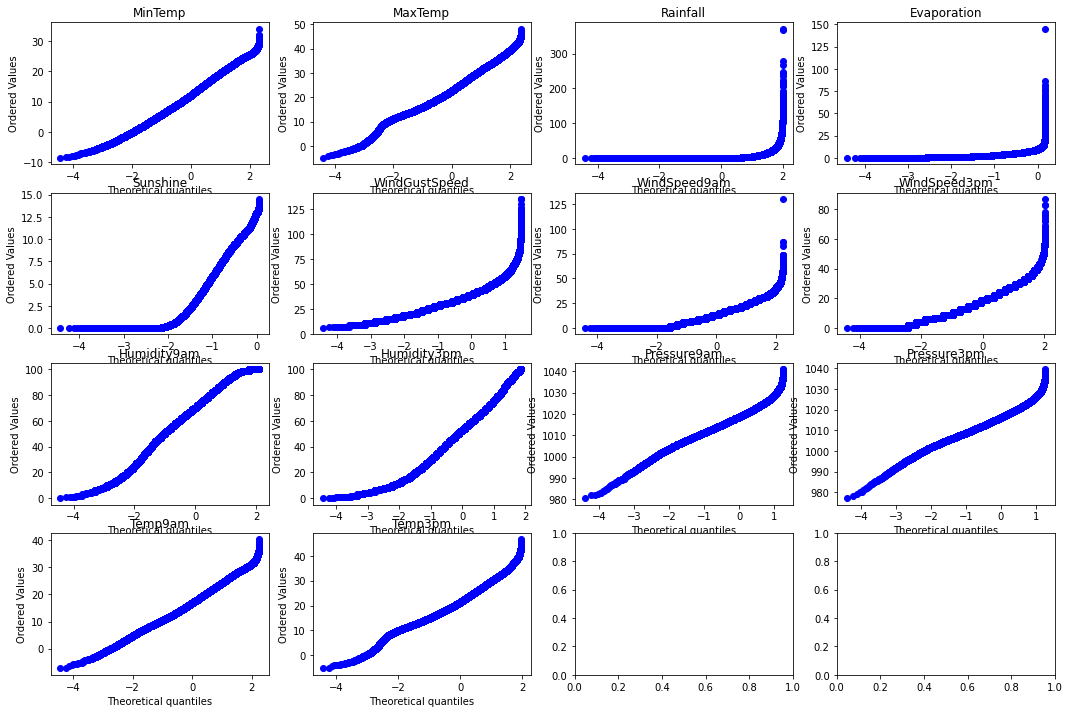

In [20]:
import scipy.stats as stats

fig,axes=plt.subplots(4,4,figsize=(18,12))
p = 0
for i in range(0,4):
  for j in range(0,4):
    if p <= 13:
      stats.probplot(df_num.iloc[:, p], dist=stats.norm, plot=axes[i][j])
      axes[i][j].set_title(df_num.columns[p])
      p = p + 1

Conclusiones:
* Las variables MinTemp, MaxTemp, Pressure3pm, Pressure9am, Temp3pm y Temp9am están distribuidas de forma normal. Esta característica se observa en el histograma y se confirma en el QQ Plot.
* De Humidity9am y Humidity3pm observamos como la humedad tiende a ser mayor con el avance del día. El valor máximo de humedad es 100, pudiendo ser el caso de una representación porcentual.
* Del histograma,  concluimos que WindSpeed9am y WindSpeed3pm presentan distribuciones sesgadas a la derecha. Del Boxplot podemos observar los outliers para hacia los valores positivos.
* La temperatura máxima y mínima tienen distribiciones normales, siendo claramente la media de la máxima mayor a la mínima.
* Rainfall y Evaporation presentan muchos valores en cero, por lo que cualquier valor positivo se reflejará como un outlier en el Boxplot. Resta entender si existe alguna relación entre los valores cero y las demás variables.


In [21]:
df_rainfall_zero = df[df.Rainfall == 0]
count_total = df.Location.value_counts()
count_zero = df_rainfall_zero.Location.value_counts()

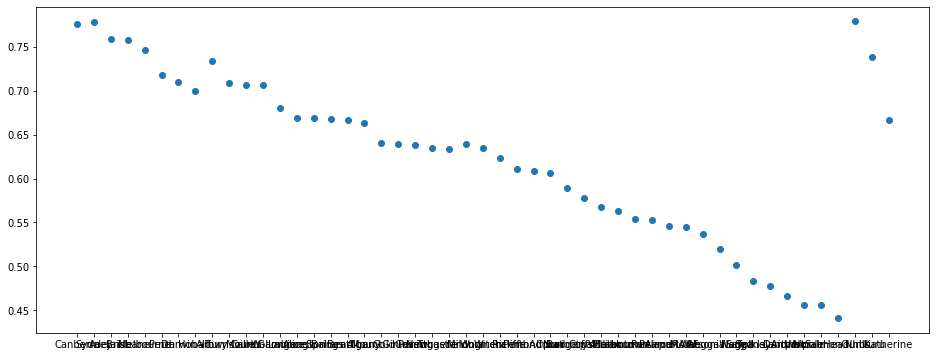

In [22]:
plt.figure(figsize=(16, 6))
rainfall_zero_percent = count_zero.values/count_total.values
plt.scatter(count_total.index, rainfall_zero_percent) 

In [23]:
df_evaporation_zero = df[df.Evaporation == 0]
count_total = df.Location.value_counts()
count_zero = df_evaporation_zero.Location.value_counts()
count_total = count_total.filter(items=count_zero.index, axis=0)

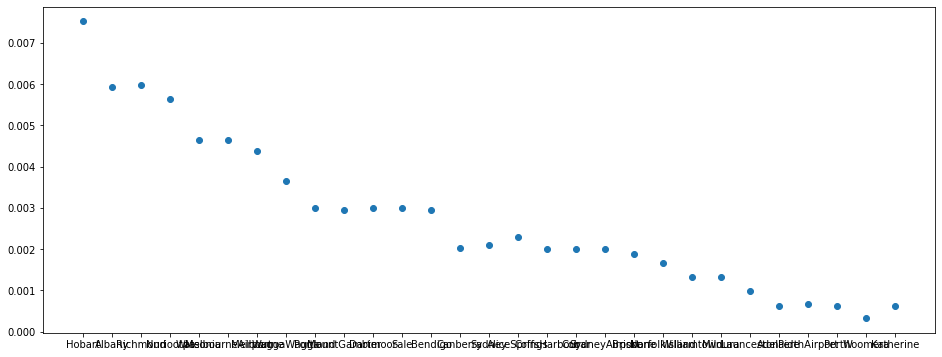

In [24]:
plt.figure(figsize=(16, 6))
evaporation_zero_percent = count_zero.values/count_total.values
plt.scatter(count_total.index, evaporation_zero_percent) 

El porcentaje de valores en cero para Rainfall supera al 45% en todas las ciudades. Debido a que cuenta con pocos valores en Nan una posible forma de imputar sería suponiendo que si ni hubo medición entonces no llovió.

El porcentaje de valores en cero para Evaporation en cambio es notablemente bajo, pero por el histograma podemos suponer que existen muchos valores cercanos a 0.  

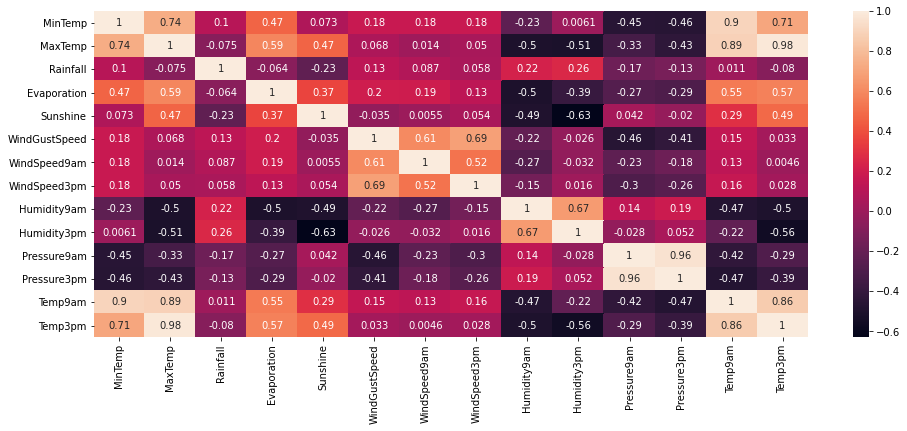

In [25]:
plt.figure(figsize=(16, 6))
sns.heatmap(df_num.corr(), annot=True )

La correlación arroja como resultado que existen relaciones lineales entre variables de la misma unidad, es decir entre Temp, Pressure y Humidity, para las distintas mediciones diarias. Se analiza entonces si la variación diaria es significativa, de manera de entender si es posible prescindir de una variable del par:

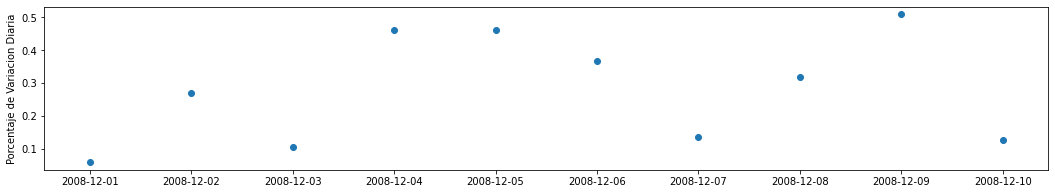

El porcentaje maximo de variacion diaria es 2%

In [26]:
pressure_dif = abs(df.Pressure3pm - df.Pressure9am)/max(df.Pressure3pm)*100
plt.figure(figsize=(18, 3))
plt.scatter(df.Date[0:10], pressure_dif[0:10])
plt.ylabel('Porcentaje de Variacion Diaria')
plt.show()
md('El porcentaje maximo de variacion diaria es {}%'.format(round(max(pressure_dif))))

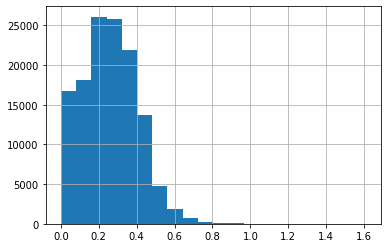

In [27]:
pressure_dif.hist(bins=20)

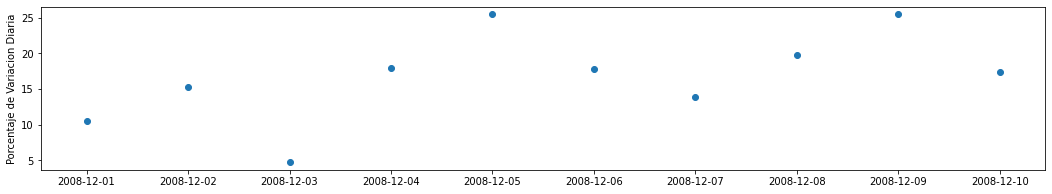

El porcentaje maximo de variacion diaria es 49%

In [28]:
temp_dif = abs(df.Temp3pm - df.Temp9am)/max(df.Temp3pm)*100
plt.figure(figsize=(18, 3))
plt.scatter(df.Date[0:10], temp_dif[0:10])
plt.ylabel('Porcentaje de Variacion Diaria')
plt.show()
md('El porcentaje maximo de variacion diaria es {}%'.format(round(max(temp_dif))))

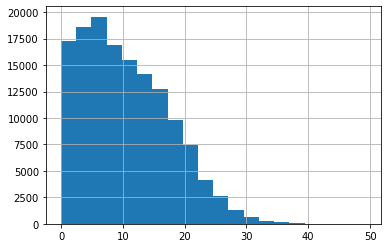

In [29]:
temp_dif.hist(bins=20)

De esta manera observamos como la variación de presión diara es muy baja en comparación a la de temperatura. Además se verifica la distribución de los porcentajes de variación para asegurarnos que el valor máximo no fue un valor aislado.

Cardinalidad de las variables categóricas.

Text(0.5, 1.0, 'Cardinalidad')

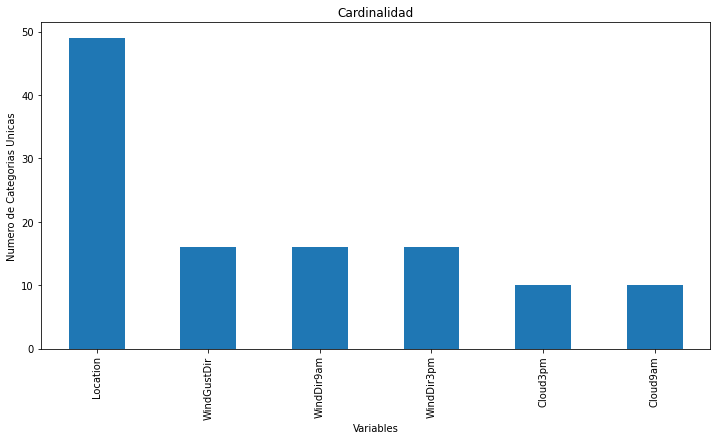

In [30]:
df_cat = df[['Location','WindGustDir', 'WindDir9am', 'WindDir3pm','Cloud3pm','Cloud9am']]
df_cat.nunique().plot.bar(figsize=(12,6))
plt.ylabel('Numero de Categorias Unicas')
plt.xlabel('Variables')
plt.title('Cardinalidad')

La variable de mayor cardinalidad es Location. Respecto a la aparición de nuevas etiquetas, sólo podría darse para Location, ya que no deberían aparecer nuevas WindDir (habiendo considerado todas en la codificación de variables) y no se esperaría valores mayores a 10 para Cloud. Esto será tenido en cuenta al momento de codificar las variables categóricas.

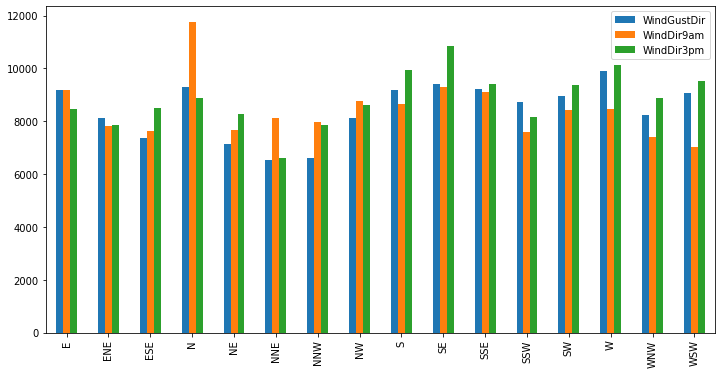

In [56]:
df_wind = df_cat.drop(['Location','Cloud3pm','Cloud9am'], axis=1)
df_wind.apply(pd.Series.value_counts).plot(figsize=(12,6), kind='bar', stacked=False)

La representatividad de las etiquetas en las categorías asociadas a Wind es pareja.

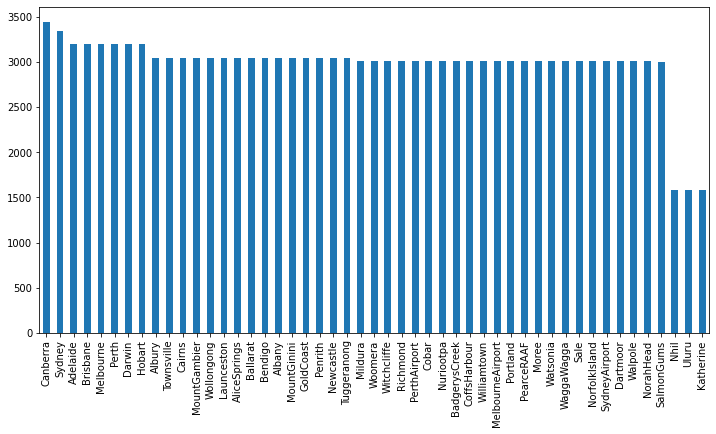

In [32]:
df_cat.Location.value_counts().plot(figsize=(12,6), kind='bar', stacked=False)

La cantidad de instancias para cada Location también es pareja.

Finalmente observamos la distribución de la variable RainToday, observando un claro sesgo.

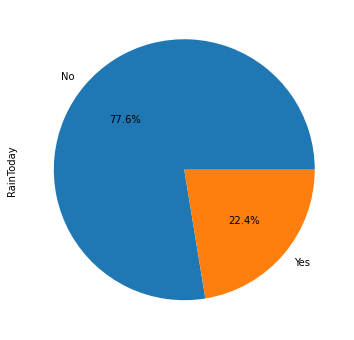

In [33]:
df.RainToday.value_counts().plot(figsize=(12,6), kind='pie', autopct='%1.1f%%')

Tratamiento de la variable compuesta Date:
* Podría ser dividida en año, mes y día, convirtiendose en variables numericas discretas.
* Si permanece como un string, entonces seria lo mismo que un id, ya que no habria dos observaciones para el mismo dia, lo cual no agregaría valor al modelo.
* Otra opción mas compleja sería entrenar un embedding de la fecha, de manera de tener una variable en vez de tres.
* También podría usarse una Binary Encoding o Feature Hashing, a costa de aumentar el número de variables.
* OneHotEncoding no está considerado debido a la gran cantidad de valores únicos.

#### Variables de Salida

La variable de salida esta claramente desbalanceada, ya que presenta 3 veces más casos negativos que positivos.

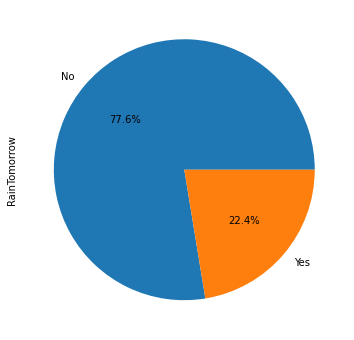

In [34]:
df.RainTomorrow.value_counts().plot(figsize=(12,6), kind='pie', autopct='%1.1f%%')

In [35]:
count = 0
for i in range(0, len(df.RainToday)):
  if df.RainToday[i] == df.RainTomorrow[i]:
    count = count + 1
percent = round(count/len(df.RainToday)*100, 2)


In [36]:
md("Un {}% de las observaciones, corresponde a casos en los que llovio al dia siguiente de un dia de lluvia (RainToday=Yes, RainTommorow=Yes).".format(percent))

Un 73.78% de las observaciones, corresponde a casos en los que llovio al dia siguiente de un dia de lluvia (RainToday=Yes, RainTommorow=Yes).

Nos encontramos ante un caso de clasificacion con dos clases de salida, por lo que la solucion mas adecuada es un Binary Enconding, donde Yes=1 y No=0. Si consideramos un modelo constante, y predecimos lluvia para un dia considerando que llovió el dia anterior, entonces obtendremos un 73,78% de acierto aproximado en el set de entrenamiento.

### 2. Esquema de validación de resultados

Partición del dataset en entrenamiento y validación.


In [100]:
X_train, X_test, y_train, y_test = split(df, test_size=0.2)

### 3. Limpieza y preparación de datos

En primer lugar revisamos los valores de salida encontrando valores faltantes. Como el porcentaje el bajo (2.2%), eliminamos las filas del dataset para evitar un overfitting al momento de imputarlos.



In [101]:
fp.status(y_train)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,RainTomorrow,2607,0.022403,0,0.0,2,object


In [102]:
# Eliminamos los Nan de la salida y sus correspodientes filas en X_train
y_train = y_train.dropna(axis=0)
X_train = X_train[X_train.index.isin(y_train.index)]

Calculamos la cantidad de observaciones y valores faltantes para cada variable. 

In [103]:
status = fp.status(X_train)
status[status['q_nan'] != 0]

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
2,MinTemp,510,0.004483,121,0.001064,386,float64
3,MaxTemp,261,0.002294,9,0.000079,499,float64
4,Rainfall,1116,0.009810,72269,0.635270,649,float64
5,Evaporation,48781,0.428802,185,0.001626,336,float64
6,Sunshine,54326,0.477545,1835,0.016130,145,float64
7,WindGustDir,7484,0.065787,0,0.000000,16,object
8,WindGustSpeed,7439,0.065391,0,0.000000,67,float64
9,WindDir9am,7993,0.070261,0,0.000000,16,object
10,WindDir3pm,3055,0.026855,0,0.000000,16,object
11,WindSpeed9am,1083,0.009520,6870,0.060390,43,float64


Se realiza un proceso completo de limpieza y preparación de datos como primera implementación y luego se agregan variantes en función de los resultados obtenidos en la validación.

Se identifican todas las variables cuyo porcentaje de Nans es menor al 5% y se refleja en un grafico de barras ordenado.

<BarContainer object of 11 artists>

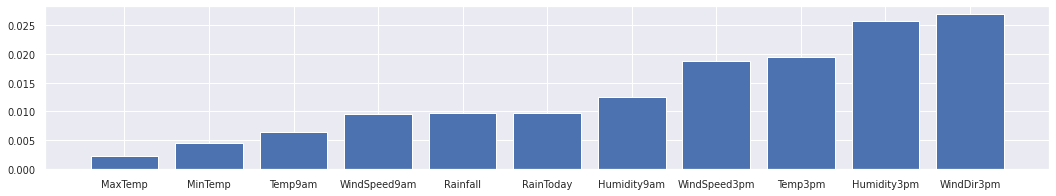

In [104]:
data_nan = status[['variable','p_nan']][(status['p_nan']<0.05) & (status['p_nan']>0)]
data_nan = data_nan.sort_values(by = ['p_nan'], axis=0)
plt.figure(figsize=(18, 3))
plt.bar(data_nan.variable, data_nan.p_nan)

Para cada una de las variables del gráfico anterior se filtran las filas con Nan y se calculan los porcentajes de Nan de todas las demás variables. La idea es entender si se da intersección de Nan entre variables.

In [105]:
for c in data_nan.variable.tolist():
  train_nan = X_train[X_train[c].isna()]
  status_nan = fp.status(train_nan)
  prom = round(sum(status_nan['p_nan'])/len(status_nan)*100,2)
  print('Considerando la porción del dataset con nan para {}, el promedio de nan de las demás variables es {}%.'.format(c,prom))

Considerando la porción del dataset con nan para MaxTemp, el promedio de nan de las demás variables es 47.13%.
Considerando la porción del dataset con nan para MinTemp, el promedio de nan de las demás variables es 51.35%.
Considerando la porción del dataset con nan para Temp9am, el promedio de nan de las demás variables es 49.97%.
Considerando la porción del dataset con nan para WindSpeed9am, el promedio de nan de las demás variables es 51.43%.
Considerando la porción del dataset con nan para Rainfall, el promedio de nan de las demás variables es 31.03%.
Considerando la porción del dataset con nan para RainToday, el promedio de nan de las demás variables es 31.03%.
Considerando la porción del dataset con nan para Humidity9am, el promedio de nan de las demás variables es 37.38%.
Considerando la porción del dataset con nan para WindSpeed3pm, el promedio de nan de las demás variables es 48.03%.
Considerando la porción del dataset con nan para Temp3pm, el promedio de nan de las demás varia

Observamos que un gran porcentaje de las demás variables presenta valores faltantes por lo que procedemos a eliminar todas las filas de las variables indicadas en el gráfico de barras anterior. Posteriormente calculamos el porcentaje de reducción del dataset para validar nuestra suposición.
Por ello procedemos a eliminar todos las filas con Nan para las variables cuyo porcentaje es menor al 5% y verificamos que porcentaje del dataset original estariamos perdiendo.

In [106]:
len_old = X_train.shape[0]
X_train = X_train.dropna(subset=data_nan.variable.to_list())
len_new = X_train.shape[0]
print('Porcentaje de reducción del dataset {}%'.format(round(100-len_new/len_old*100,2)))

Porcentaje de reducción del dataset 5.38%


Se genera una función drop_nan la cual permite eliminar las filas con valores nan, considerando las variables cuyo porcentaje de nan sea menor a un valor customizable. La misma luego acomoda los índices con la salida para evitar incongruencias.

A partir de aquí nos quedamos con una lista de variables que aún tienen valores Nan. Realizaremos la imputación sólo sobre estas variables, corriendo el riesgo que si en el dataset de testeo apareciera alguna otra faltante podría dar un error en la predicción. La práctica óptima sería tener un método de imputación para cada variable, independientemente si presenta valores faltantes en el dataset de train o no.

In [107]:
status_2 = fp.status(X_train)
status_2[status_2['q_nan']!=0]

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
5,Evaporation,44971,0.417799,172,0.001598,330,float64
6,Sunshine,49529,0.460144,1771,0.016453,145,float64
7,WindGustDir,4828,0.044854,0,0.000000,16,object
8,WindGustSpeed,4819,0.044770,0,0.000000,66,float64
9,WindDir9am,6029,0.056012,0,0.000000,16,object
15,Pressure9am,8997,0.083586,0,0.000000,540,float64
16,Pressure3pm,8948,0.083130,0,0.000000,536,float64
17,Cloud9am,40155,0.373056,6403,0.059486,10,float64
18,Cloud3pm,41243,0.383164,3859,0.035852,10,float64


Procedemos a imputar las variables numéricas. 
Usaremos una imputación por media sobre Pressure3pm y Pressure9am, debido a su distribución normal.

In [108]:
X_train.loc[:,:] = simple_imputer(X_train, 'Pressure3pm', strategy='mean')
X_train.loc[:,:] = simple_imputer(X_train, 'Pressure9am', strategy='mean')

Para Evaporation y WindGustSpeed usaremos una imputación por mediana, ya que si usamos algún valor arbitrario podríamos modificar la distribución o hasta generar mayor cantidad de ouliers.

In [109]:
X_train.iloc[:,:] = simple_imputer(X_train, 'Evaporation', strategy='median')
X_train.iloc[:,:] = simple_imputer(X_train, 'WindGustSpeed', strategy='median')

Para lo valores faltante de Sunshine usaremos 0.

In [110]:
X_train.loc[:, 'Sunshine'] = X_train['Sunshine'].replace(np.nan, 0, regex=True)

Los valores faltantes de Cloud3pm y Cloud9am son completadas con el valor 0 para no agregar una nueva categoría.

In [111]:
X_train.loc[:, 'Cloud3pm'] = X_train['Cloud3pm'].replace(np.nan, 0, regex=True)
X_train.loc[:, 'Cloud9am'] = X_train['Cloud9am'].replace(np.nan, 0, regex=True)

Para el caso de WindgustDir y WindDir9am completamos la faltante con una nueva categoría. También podría elegirse la dirección más probable considerando la salida. 

In [112]:
X_train.loc[:, 'WindGustDir'] = X_train['WindGustDir'].replace(np.nan, 'Faltante', regex=True)
X_train.loc[:, 'WindDir9am'] = X_train.loc[:, 'WindDir9am'].replace(np.nan, 'Faltante', regex=True)

Las variables categóricas a imputar corresponden a las direcciones de los vientos. Una forma de representarlos es a través de los ángulos asociados de 0° a 360°. (https://www.surfertoday.com/windsurfing/how-to-read-wind-direction). Para el caso Nan reemplazado por la palabra "Faltante" utilizamos el número -1.

In [113]:
dic = {'SE': 135, 'SSE': 157.5, 'W': 270, 'N':0, 'ENE':67.5, 'NW': 315, 'SSW': 202.5, 'SW':225, 'ESE': 112.5,
       'S': 180, 'NNW': 337.5, 'Faltante': -1, 'NNE': 22.5, 'E': 90, 'WSW': 247.5, 'WNW': 292.5, 'NE': 45}

In [114]:
X_train.loc[:, 'WindGustDir'] = X_train['WindGustDir'].map(dic)
X_train.loc[:, 'WindDir9am'] = X_train['WindDir9am'].map(dic)
X_train.loc[:, 'WindDir3pm'] = X_train['WindDir3pm'].map(dic)

Tanto para la salida, como para la variable RainToday llevamos a cabo una codificación binaria ya que sólo toma uno de dos valores posibles.

In [115]:
X_train.loc[:, 'RainToday'] = X_train.loc[:, 'RainToday'].map({'No': 0, 'Yes': 1})
y_train = y_train.map({'No': 0, 'Yes': 1})

La fecha es dividida en año, mes y dia, todas como variables enteras.

In [116]:
date = X_train.Date.str.split(pat='-', expand=True)

Location puede ser codificada de diversas maneras:
* OneHotEncoding: simple pero agregaría una cantidad de variables igual a la cantidad de ciudades.
* Binary Encoding: permite trabajar con menos variables que OneHotEncoding pero podría no estar representando correctamente la relación en distintas etiquetas.
* Latitude & Longitude: se podría conseguir la Latitud/Longitud de las ciudades para representarlas.
* Embedding: se podría crear un embedding, ya sea a partir de sólo el nombre (lo cual no mapaería de la manera más precisa la relación).

In [117]:
encoded_locations = binary_encoder(X_train['Location'])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [118]:
encoded_locations

,Location_0,Location_1,Location_2,Location_3,Location_4,Location_5,Location_6
142528,0,0,0,0,0,0,1
65304,0,0,0,0,0,1,0
40651,0,0,0,0,0,1,1
97487,0,0,0,0,1,0,0
103132,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...
110268,0,0,1,0,0,0,1
119879,0,1,0,1,1,0,1
103694,0,0,0,0,1,0,1
131932,0,0,1,1,1,1,1


Para el caso en que se eliminan filas con valores Nan es necesario realizar lo mismo sobre la salida (usando el indice de las variables) para evitar que se mezcle la información.

In [119]:
y_train = y_train[y_train.index.isin(X_train.index)]

Reseteamos los indices y concatenamos las fechas, ciudades y las demás variables. Luego finalmente eliminamos las columnas de las variables categóricas originales.

In [120]:
X_train.reset_index(drop=True, inplace=True)
date.reset_index(drop=True, inplace=True)
encoded_locations.reset_index(drop=True, inplace=True)

In [121]:
df_train = pd.concat([X_train, date], axis=1)
X_train = pd.concat([X_train, date, encoded_locations], axis=1)

In [122]:
X_train = X_train.drop(['Location', 'Date'], axis=1)

Una vez imputados los datos faltantes y codificadas las variables categóricas procedemosa identificar las variables de entrada de más importancia.

In [123]:
df_train['RainTomorrow'] = y_train.values

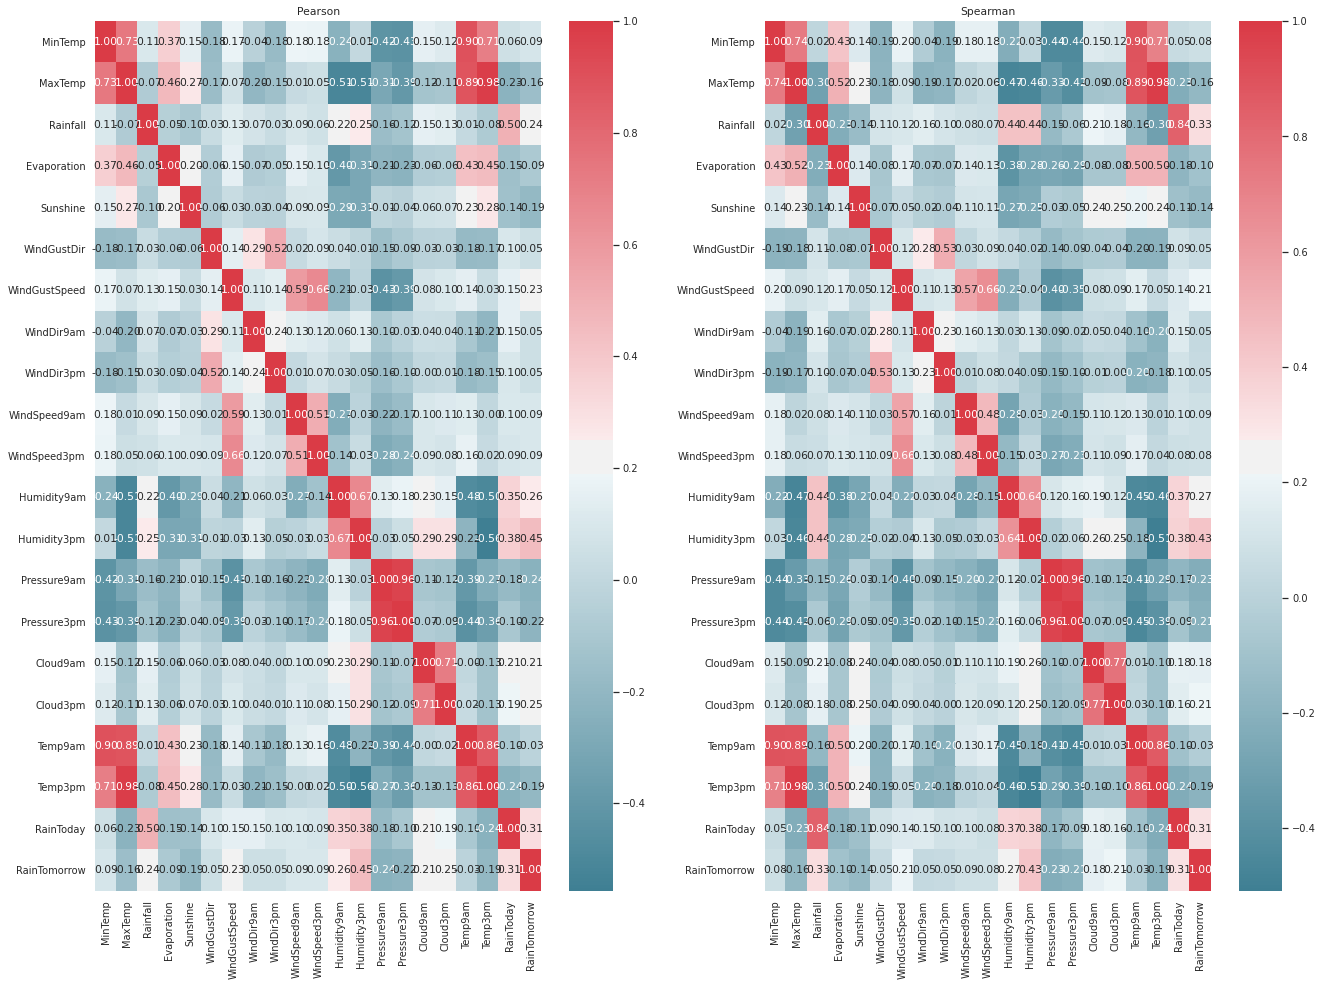

In [124]:
fig, axes = plt.subplots(1,2,figsize=(22,16))

r = df_train.corr(method='pearson')
axes[0].set_title("Pearson")
sns.heatmap(r, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f",ax=axes[0])
sns.set(font_scale=0.9)

rho = df_train.corr(method='spearman')
axes[1].set_title("Spearman")
sns.heatmap(rho, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f")
sns.set(font_scale=0.9)

Podemos observar que tanto para el coeficiente de Pearson como Spearman, la salida no presenta una correlación lineal significativa con alguna de las variables de entrada. Las relaciones más prepoderantes se dan con la humedad de tarde y la condición de lluvia/ no lluvia del día actual.

### 4. Entrenamiento de modelos

Dado que estamos frente a un problema de clasificación, haremos uso de dos modelo: LogisticRegression y RandomForest, un método lineal y uno no lineal. Como nuestro foco está en el preprocesamiento de los datos, usaremos los hiperpámetros por defecto, variando de caso a caso sólo los métodos anterios tales como imputación, codificación o ingeniería de features.

Siendo un dataset desbalanceado usamos la métrica de validación BalancedAccury, definida como el promedio del Recall obtenido en cada clase.

Realizamos un escalado de las variables haciendo uso StandardScaler.

In [12]:
from sklearn.preprocessing import StandardScaler 
std = StandardScaler() 
X_train = std.fit_transform(X_train)
X_test = std.fit_transform(X_test)

In [13]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
from sklearn.metrics import balanced_accuracy_score
y_train_pred = clf.predict(X_train)
score_train = balanced_accuracy_score(y_train, y_train_pred)

In [15]:
print("Balanced Accuracy sobre el set de entrenamiento {} %".format(round(score_train,4)*100))

Balanced Accuracy sobre el set de entrenamiento 72.27 %


In [17]:
y_test_pred = clf.predict(X_test)
score_train_test = balanced_accuracy_score(y_test, y_test_pred)

In [18]:
print("Precisión sobre el set de testeo {} %".format(round(score_train_test,4)*100))

Precisión sobre el set de testeo 72.05 %


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler  

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
y_train_pred = rf.predict(X_train)
score_train = balanced_accuracy_score(y_train, y_train_pred)

In [22]:
print("Balanced Accuracy sobre el set de entrenamiento {} %".format(round(score_train,4)*100))

Balanced Accuracy sobre el set de entrenamiento 100.0 %


In [23]:
y_test_pred = rf.predict(X_test)
score_train_test = balanced_accuracy_score(y_test, y_test_pred)

In [24]:
print("Precisión sobre el set de testeo {} %".format(round(score_train_test,4)*100))

Precisión sobre el set de testeo 72.82 %




### 5. Evaluación de resultados y conclusiones

- ¿Qué puede concluir acerca de los modelos y preparaciones de datos ensayadas? Tener en cuenta como cada preparación afecta a los distintos modelos.

### Funciones

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce
from sklearn.decomposition import PCA


# Separa el dataset en train y test, además de separar las variables de entrada de las de salida.
# inputs: df (DataFrame), test_size (Tamaño del test set) 
def split (df, test_size):
  X = df.iloc[: ,:-1]
  y = df.iloc[:,-1]
  train_set, test_set, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return train_set, test_set, y_train, y_test

# Elimina las filas con nan para las variables que poseen un porcentaje de nan < percent
def drop_nan (X, y, percent = 5):
  y = y.dropna(axis=0)
  X = X[X.index.isin(y.index)]

  status = fp.status(X)
  data_nan = status[['variable','p_nan']][(status['p_nan']<percent/100) & (status['p_nan']>0)]
  len_old = X.shape[0]
  X_new = X.dropna(subset=data_nan.variable.to_list())
  len_new = X_new.shape[0]
  left = round(100-len_new/len_old*100,2)
  return X_new, y, left

def simple_imputer(df, var, strategy): 
  imputer = SimpleImputer(strategy= strategy,add_indicator=True)
  imp = imputer.fit_transform(df[var].values.reshape(-1, 1))
  df.loc[:, var] = imp[:, 0]
  return df


def one_hot_encoder(col):
  ohe_encoder = OneHotEncoder(categories='auto',drop=None, sparse=False) 
  ohe = ohe_encoder.fit_transform(col.values.reshape(-1, 1))
  cat_names = np.concatenate(ohe_encoder.categories_).ravel()
  enconded_vars = pd.DataFrame(ohe, columns=cat_names).astype(int)
  return enconded_vars

def binary_encoder(col):
  encoder = ce.BinaryEncoder()
  data_encoded = encoder.fit_transform(col) 
  return data_encoded


dic = {'SE': 135, 'SSE': 157.5, 'W': 270, 'N':0, 'ENE':67.5, 'NW': 315, 'SSW': 202.5, 'SW':225, 'ESE': 112.5,
       'S': 180, 'NNW': 337.5, 'Faltante': -1, 'NNE': 22.5, 'E': 90, 'WSW': 247.5, 'WNW': 292.5, 'NE': 45}


### Casos de Análisis

In [45]:
# Caso 1
# - Elimino filas con Nan para las variables con porcentaje de Nan < 5%
# - Separo Date en Dia, Mes y Año
# - Location con Binary Encoder
def caso_01(X, y):
  X, y, left = drop_nan(X, y, percent=5)
  X.loc[:,:] = simple_imputer(X, 'Pressure3pm', strategy='mean')
  X.loc[:,:] = simple_imputer(X, 'Pressure9am', strategy='mean')
  X.iloc[:,:] = simple_imputer(X, 'Evaporation', strategy='median')
  X.iloc[:,:] = simple_imputer(X, 'WindGustSpeed', strategy='median')
  X.loc[:, 'Sunshine'] = X['Sunshine'].replace(np.nan, 0, regex=True)
  X.loc[:, 'Cloud3pm'] = X['Cloud3pm'].replace(np.nan, 0, regex=True)
  X.loc[:, 'Cloud9am'] = X['Cloud9am'].replace(np.nan, 0, regex=True)
  X.loc[:, 'WindGustDir'] = X['WindGustDir'].replace(np.nan, 'Faltante', regex=True)
  X.loc[:, 'WindDir9am'] = X.loc[:, 'WindDir9am'].replace(np.nan, 'Faltante', regex=True)
  X.loc[:, 'WindGustDir'] = X['WindGustDir'].map(dic)
  X.loc[:, 'WindDir9am'] = X['WindDir9am'].map(dic)
  X.loc[:, 'WindDir3pm'] = X['WindDir3pm'].map(dic)
  X.loc[:, 'RainToday'] = X.loc[:, 'RainToday'].map({'No': 0, 'Yes': 1})
  y = y.map({'No': 0, 'Yes': 1})
  date = X.Date.str.split(pat='-', expand=True)
  encoded_locations = binary_encoder(X['Location'])
  y = y[y.index.isin(X.index)]
  X.reset_index(drop=True, inplace=True)
  date.reset_index(drop=True, inplace=True)
  encoded_locations.reset_index(drop=True, inplace=True)
  df_train = pd.concat([X, date], axis=1)
  X = pd.concat([X, date, encoded_locations], axis=1)
  X = X.drop(['Location', 'Date'], axis=1)
  std = StandardScaler() 
  X= std.fit_transform(X)
  return X, y

In [46]:
# Caso 2
# - CCA
# - Separo Date en Dia, Mes y Año
# - Location con Binary Encoder
def caso_02(X, y):
  X, y, left = drop_nan(X, y, percent=100)
  X.loc[:,:] = simple_imputer(X, 'Pressure3pm', strategy='mean')
  X.loc[:,:] = simple_imputer(X, 'Pressure9am', strategy='mean')
  X.iloc[:,:] = simple_imputer(X, 'Evaporation', strategy='median')
  X.iloc[:,:] = simple_imputer(X, 'WindGustSpeed', strategy='median')
  X.loc[:, 'Sunshine'] = X['Sunshine'].replace(np.nan, 0, regex=True)
  X.loc[:, 'Cloud3pm'] = X['Cloud3pm'].replace(np.nan, 0, regex=True)
  X.loc[:, 'Cloud9am'] = X['Cloud9am'].replace(np.nan, 0, regex=True)
  X.loc[:, 'WindGustDir'] = X['WindGustDir'].replace(np.nan, 'Faltante', regex=True)
  X.loc[:, 'WindDir9am'] = X.loc[:, 'WindDir9am'].replace(np.nan, 'Faltante', regex=True)
  X.loc[:, 'WindGustDir'] = X['WindGustDir'].map(dic)
  X.loc[:, 'WindDir9am'] = X['WindDir9am'].map(dic)
  X.loc[:, 'WindDir3pm'] = X['WindDir3pm'].map(dic)
  X.loc[:, 'RainToday'] = X.loc[:, 'RainToday'].map({'No': 0, 'Yes': 1})
  y = y.map({'No': 0, 'Yes': 1})
  date = X.Date.str.split(pat='-', expand=True)
  encoded_locations = binary_encoder(X['Location'])
  y = y[y.index.isin(X.index)]
  X.reset_index(drop=True, inplace=True)
  date.reset_index(drop=True, inplace=True)
  encoded_locations.reset_index(drop=True, inplace=True)
  df_train = pd.concat([X, date], axis=1)
  X = pd.concat([X, date, encoded_locations], axis=1)
  X = X.drop(['Location', 'Date'], axis=1)
  std = StandardScaler() 
  X= std.fit_transform(X)
  return X, y

In [47]:
# Caso 3
# - Elimino filas con Nan para las variables con porcentaje de Nan < 5%
# - Separo Date en Dia, Mes y Año
# - Location con Binary Encoder
# - PCA
def caso_03(X, y):
  X, y, left = drop_nan(X, y, percent=5)
  X.loc[:,:] = simple_imputer(X, 'Pressure3pm', strategy='mean')
  X.loc[:,:] = simple_imputer(X, 'Pressure9am', strategy='mean')
  X.iloc[:,:] = simple_imputer(X, 'Evaporation', strategy='median')
  X.iloc[:,:] = simple_imputer(X, 'WindGustSpeed', strategy='median')
  X.loc[:, 'Sunshine'] = X['Sunshine'].replace(np.nan, 0, regex=True)
  X.loc[:, 'Cloud3pm'] = X['Cloud3pm'].replace(np.nan, 0, regex=True)
  X.loc[:, 'Cloud9am'] = X['Cloud9am'].replace(np.nan, 0, regex=True)
  X.loc[:, 'WindGustDir'] = X['WindGustDir'].replace(np.nan, 'Faltante', regex=True)
  X.loc[:, 'WindDir9am'] = X.loc[:, 'WindDir9am'].replace(np.nan, 'Faltante', regex=True)
  X.loc[:, 'WindGustDir'] = X['WindGustDir'].map(dic)
  X.loc[:, 'WindDir9am'] = X['WindDir9am'].map(dic)
  X.loc[:, 'WindDir3pm'] = X['WindDir3pm'].map(dic)
  X.loc[:, 'RainToday'] = X.loc[:, 'RainToday'].map({'No': 0, 'Yes': 1})
  y = y.map({'No': 0, 'Yes': 1})
  date = X.Date.str.split(pat='-', expand=True)
  encoded_locations = binary_encoder(X['Location'])
  y = y[y.index.isin(X.index)]
  X.reset_index(drop=True, inplace=True)
  date.reset_index(drop=True, inplace=True)
  encoded_locations.reset_index(drop=True, inplace=True)
  df_train = pd.concat([X, date], axis=1)
  X = pd.concat([X, date, encoded_locations], axis=1)
  X = X.drop(['Location', 'Date'], axis=1)
  std = StandardScaler() 
  X= std.fit_transform(X)
  pca = PCA(n_components=4)
  X = pca.fit_transform(X)
  return X, y

In [48]:
# Caso 4
# - Elimino filas con Nan para las variables con porcentaje de Nan < 5%
# - Separo Date en Dia, Mes y Año
# - Location con Binary Encoder
# - MinMax Scaler
def caso_04(X, y):
  X, y, left = drop_nan(X, y, percent=5)
  X.loc[:,:] = simple_imputer(X, 'Pressure3pm', strategy='mean')
  X.loc[:,:] = simple_imputer(X, 'Pressure9am', strategy='mean')
  X.iloc[:,:] = simple_imputer(X, 'Evaporation', strategy='median')
  X.iloc[:,:] = simple_imputer(X, 'WindGustSpeed', strategy='median')
  X.loc[:, 'Sunshine'] = X['Sunshine'].replace(np.nan, 0, regex=True)
  X.loc[:, 'Cloud3pm'] = X['Cloud3pm'].replace(np.nan, 0, regex=True)
  X.loc[:, 'Cloud9am'] = X['Cloud9am'].replace(np.nan, 0, regex=True)
  X.loc[:, 'WindGustDir'] = X['WindGustDir'].replace(np.nan, 'Faltante', regex=True)
  X.loc[:, 'WindDir9am'] = X.loc[:, 'WindDir9am'].replace(np.nan, 'Faltante', regex=True)
  X.loc[:, 'WindGustDir'] = X['WindGustDir'].map(dic)
  X.loc[:, 'WindDir9am'] = X['WindDir9am'].map(dic)
  X.loc[:, 'WindDir3pm'] = X['WindDir3pm'].map(dic)
  X.loc[:, 'RainToday'] = X.loc[:, 'RainToday'].map({'No': 0, 'Yes': 1})
  y = y.map({'No': 0, 'Yes': 1})
  date = X.Date.str.split(pat='-', expand=True)
  encoded_locations = binary_encoder(X['Location'])
  y = y[y.index.isin(X.index)]
  X.reset_index(drop=True, inplace=True)
  date.reset_index(drop=True, inplace=True)
  encoded_locations.reset_index(drop=True, inplace=True)
  df_train = pd.concat([X, date], axis=1)
  X = pd.concat([X, date, encoded_locations], axis=1)
  X = X.drop(['Location', 'Date'], axis=1)
  mms = MinMaxScaler() 
  X= mms.fit_transform(X)
  return X, y

In [49]:
data = np.zeros(shape=(4,4))
resultados = pd.DataFrame(data=data, index=['caso_01', 'caso_02', 'caso_03', 'caso_04'], 
                          columns=['LogReg Train','LogReg Test','RandomForest Train', 'RandomForest Test'])

In [ ]:
casos = [caso_01, caso_02, caso_03, caso_04]
i = 0
for caso in casos:
  X_train, X_test, y_train, y_test = split(df, test_size=0.2)
  X_train, y_train = caso(X_train, y_train)
  X_test, y_test = caso(X_test, y_test)

  clf.fit(X_train, y_train)
  y_train_pred = clf.predict(X_train)
  score_train = balanced_accuracy_score(y_train, y_train_pred)
  resultados.iloc[i, 0] = round(score_train,4)*100

  y_test_pred = clf.predict(X_test)
  score_test = balanced_accuracy_score(y_test, y_test_pred)
  resultados.iloc[i, 1] = round(score_test,4)*100

  rf.fit(X_train, y_train)
  y_train_pred = rf.predict(X_train)
  score_train = balanced_accuracy_score(y_train, y_train_pred)
  resultados.iloc[i, 2] = round(score_train,4)*100

  y_test_pred = rf.predict(X_test)
  score_test = balanced_accuracy_score(y_test, y_test_pred)
  resultados.iloc[i, 3] = round(score_test,4)*100

  i = i+1

In [51]:
resultados

,LogReg Train,LogReg Test,RandomForest Train,RandomForest Test
caso_01,72.27,72.05,100.0,72.74
caso_02,74.23,73.67,100.0,73.83
caso_03,66.24,66.17,100.0,66.25
caso_04,72.19,67.90,100.0,71.64


### 7. Presentación de resultados

- Elabore un informe de dos o tres páginas describiendo el procedimiento realizado y las conclusiones importantes indicando la ruta del código fuente en git.